# ФЫ

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


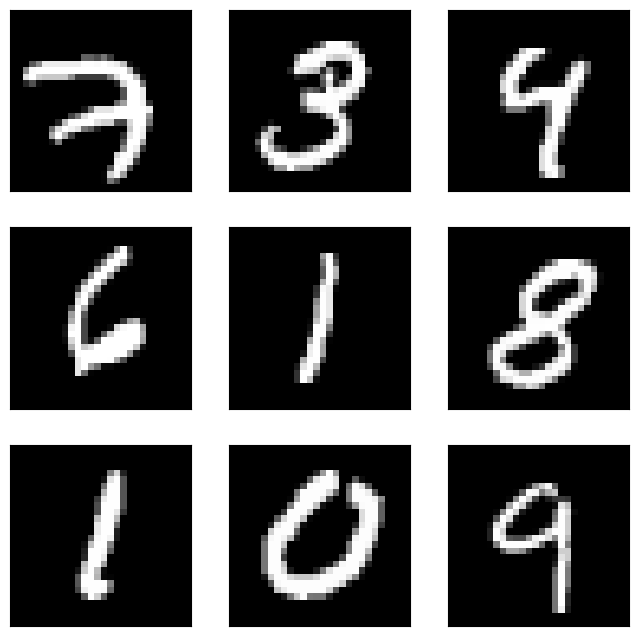

D:\Users\Даниил\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
D:\Users\Даниил\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


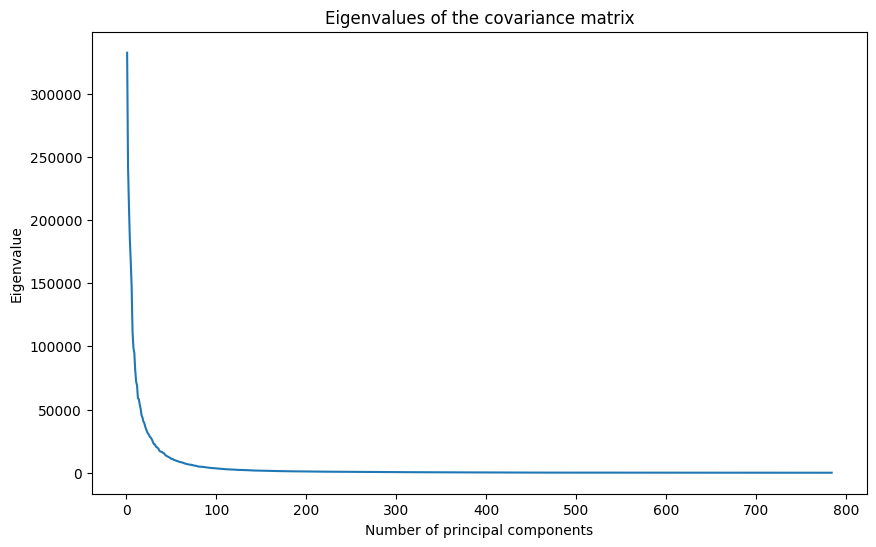

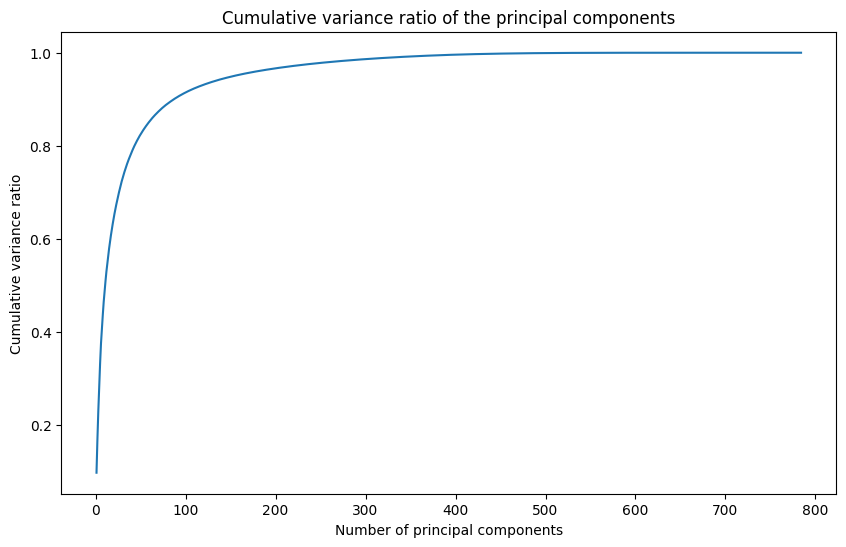

The first 15 principal components cover 57.91+0.00j% of the total variance.


D:\Users\Даниил\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


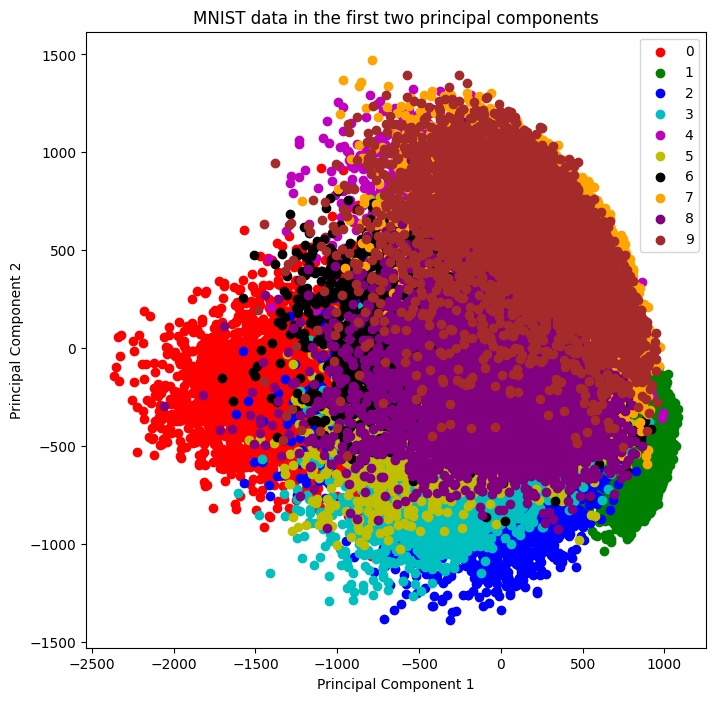

In [ ]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from mnist import load_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load MNIST dataset
train, validation, test = load_mnist()
X_train, y_train = train
X_test, y_test = test

# Reshape the data
n_samples_train = X_train.shape[0]
height, width = X_train.shape[1], X_train.shape[2]
X_train = X_train.reshape(n_samples_train, height * width)

n_samples_test = X_test.shape[0]
X_test = X_test.reshape(n_samples_test, height * width)

# Visualize some examples from the dataset
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(X_train[i].reshape(28, 28), cmap='gray')
    axi.set(xticks=[], yticks=[])
plt.show()

# Implement PCA
class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eigenvectors = None
        self.eigenvalues = None

    def fit(self, X):
        # 1. Center the data
        self.X_centered = X - X.mean(axis=0)

        # 2. Compute the covariance matrix
        self.covariance_matrix = np.dot(self.X_centered.T, self.X_centered) / (X.shape[0] - 1)

        # 3. Compute the eigenvalues and eigenvectors
        self.eigenvalues, self.eigenvectors = np.linalg.eig(self.covariance_matrix)
        self.eigenvectors = self.eigenvectors.T  # Transpose the eigenvectors

        # Sort the eigenvalues and eigenvectors in descending order
        indices = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[indices]
        self.eigenvectors = self.eigenvectors[indices]

        if self.n_components is not None:
            self.eigenvectors = self.eigenvectors[:self.n_components]

    def transform(self, X):
        # 4. Transform the data to the new coordinate system
        return np.dot(X - X.mean(axis=0), self.eigenvectors.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# Implement kNN
class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        distances = []
        for x in X:
            distances.append([(np.linalg.norm(x - xt), yt) for xt, yt in zip(self.X_train, self.y_train)])
        
        predictions = []
        for dists in distances:
            dists.sort(key=lambda x: x[0])
            neighbors = [dist[1] for dist in dists[:self.n_neighbors]]
            predictions.append(max(set(neighbors), key=neighbors.count))

        return np.array(predictions)

# Perform PCA
pca = my_PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Plot the eigenvalues and the cumulative variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.eigenvalues) + 1), pca.eigenvalues)
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the covariance matrix')
plt.show()

plt.figure(figsize=(10, 6))
cumulative_variance_ratio = np.cumsum(pca.eigenvalues) / np.sum(pca.eigenvalues)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative variance ratio')
plt.title('Cumulative variance ratio of the principal components')
plt.show()

print(f"The first 15 principal components cover {cumulative_variance_ratio[14]*100:.2f}% of the total variance.")

# Visualize the data in the first two principal components
plt.figure(figsize=(8, 8))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
for i in range(10):
    plt.scatter(X_train_pca[y_train == i, 0], X_train_pca[y_train == i, 1], c=colors[i], label=str(i))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('MNIST data in the first two principal components')
plt.legend()
plt.show()

# Perform kNN classification
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)

knn = my_kNN(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)
y_pred = knn.predict(X_test_knn)
accuracy = accuracy_score(y_test_knn, y_pred)
print(f"Accuracy of the kNN classifier: {accuracy:.2f}")

# Optimize the kNN classifier
best_accuracy = 0
best_n_neighbors = 0
best_n_components = 0

for n_neighbors in range(1, 31):
    for n_components in range(1, 65):
        pca = my_PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)

        knn = my_kNN(n_neighbors=n_neighbors)
        knn.fit(X_train_knn, y_train_knn)
        y_pred = knn.predict(X_test_knn)
        accuracy = accuracy_score(y_test_knn, y_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_neighbors = n_neighbors
            best_n_components = n_components

print(f"Best accuracy: {best_accuracy:.2f}")
print(f"Best number of neighbors: {best_n_neighbors}")
print(f"Best number of principal components: {best_n_components}")

Эти изображения обеспечивают визуализацию, связанную с анализом главных компонент (PCA), выполненным для набора данных MNIST.

Изображение 1: На этом графике показаны собственные значения ковариационной матрицы данных MNIST. По оси x отложено количество основных компонентов, а по оси y - соответствующие собственные значения. Собственные значения представляют собой величину дисперсии, отраженную в каждом главном компоненте. На графике показано резкое снижение собственных значений, что указывает на то, что исходные главные компоненты отражают значительную часть общей дисперсии данных.

Рисунок 2: На этом графике показан суммарный коэффициент дисперсии, объясняемый основными компонентами. По оси x отложено количество основных компонентов, а по оси y - суммарная доля дисперсии, учитываемая соответствующим количеством основных компонентов. Кривая показывает быстрый рост, что говорит о том, что относительно небольшое число основных компонентов может отразить значительную часть общей дисперсии в данных.

Изображение 3: На этом точечном графике представлены данные MNIST, спроецированные на первые два основных компонента. Каждая точка представляет отдельное изображение из набора данных, а цвета соответствуют различным классам цифр (0-9). График показывает, что данные, как правило, образуют отдельные кластеры с некоторым перекрытием между определенными классами цифр. Эта визуализация может дать представление о том, насколько хорошо основные компоненты могут разделять различные классы цифр в малоразмерном пространстве.

В совокупности эти графики помогают оценить эффективность PCA в сборе и представлении основных характеристик набора данных MNIST с использованием меньшего числа основных компонентов. Графики собственных значений и коэффициента кумулятивной дисперсии помогают выбрать соответствующее количество главных компонент, в то время как точечная диаграмма позволяет визуально проверить разделимость классов цифр в сокращенном пространстве главных компонент.